In [1]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import pandas as pd

# Yelps example

In [2]:
yelps = pd.read_csv('data/sentiment/yelps.csv')
# Shuffle df
yelps = yelps.sample(frac=1)

In [3]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    """ clean yelps reviews """
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    return re.findall(r"\w\w+",s) # Returns list of words containing [_a-zA-Z0-9] longer than one character.

*Create a count vectorizer, using the preprocessor and tokenizer from above use TruncatedSVD from Sklearn to generate a term embedding matrix for your data that is 100 dimensional in size. Embed your documents via that term embedding matrix*

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD  

# 1. The original TF matrix
vectorizer = CountVectorizer(preprocessor = clean_yelp,tokenizer = tokenize)
tf_mat = vectorizer.fit_transform(yelps.text)

# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD
svd = TruncatedSVD(n_components=100)
emb_mat = svd.fit_transform(tf_mat)

/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


*Test your vector representations using test_holdout_vectors for several levels of "cutoff".*

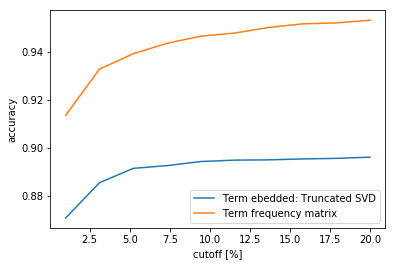

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    """
    This function simulates training on a small part of your data and testing on the rest.
    Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
    This is essentially a semi-supervised situation. 
    """
    model = LogisticRegression(solver='lbfgs',max_iter= 1000)
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

# Specifying different cut-off levels
cutoffs = np.linspace(1000,20000,10, dtype= int)
# Obtain accuracy using term frequency matrix only
acc_tf_mat = [test_holdout_vectors(tf_mat,yelps.positive,cutoff) for cutoff in cutoffs]
# Obtain accuracy for embedding generated via SVD
acc_emb_mat = [test_holdout_vectors(emb_mat,yelps.positive,cutoff) for cutoff in cutoffs]


# Plotting
plt.plot(cutoffs/len(yelps.positive)*100,acc_emb_mat)
plt.plot(cutoffs/len(yelps.positive)*100,acc_tf_mat)
plt.xlabel("cutoff [%]")
plt.ylabel("accuracy")
plt.legend(["Term ebedded: Truncated SVD","Term frequency matrix"])

#### Remarks

TF matrix performs better than the truncated SVD tf matrix but the computation time increases notably.

*Create another term embedding via Word2Vec, also 100 dimensional. Pass the cleaned and tokenized yelp reviews as "sentences" to your model to build the vocabulary and train the word vectors.*

In [6]:
from gensim.models import Word2Vec

# Cleaning and tokenizing yelp reviews
sentences =  list(map(lambda x: tokenize(clean_yelp(x)),yelps.text))

# word2vec model training
model = Word2Vec(sentences = sentences, # training data
                 workers=10,  # number of threads
                 min_count = 10, # Ignoring words that appear less than min count in the corpus
                 size=100, # word embedding vector size
                 window=10, # context window (number of words in the context window
                 sg = 1, # skip-gram algorithm
                )

/home/jrd/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/jrd/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Be

*See how this improves the scores in the classification task using test_holdout_vectors -- is word2vec better? 
At what training-set sizes does it help more?*

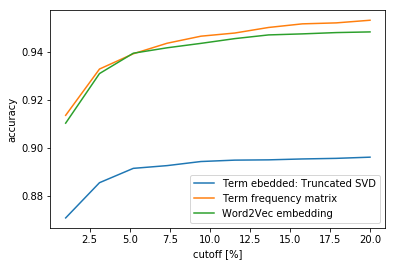

In [7]:
def embed_w2v(tokens, w2v):
    """embed your Yelp reviews using the word2vec word embeddings. 
    Each review will be a normalized sum of the words that it is made of. """
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :],axis=0)
    a /= np.linalg.norm(a)
    return a

# Embedding yelps reviews as normalized sum of word embedding vectors
w2v_embed = np.array([embed_w2v(t, model) for t in sentences])

# Obtain accuracy 
acc_w2v = [test_holdout_vectors(w2v_embed,yelps.positive,cutoff) for cutoff in cutoffs]


# Plotting
plt.plot(cutoffs/len(yelps.positive)*100,acc_emb_mat)
plt.plot(cutoffs/len(yelps.positive)*100,acc_tf_mat)
plt.plot(cutoffs/len(yelps.positive)*100,acc_w2v)
plt.xlabel("cutoff [%]")
plt.ylabel("accuracy")
plt.legend(["Term ebedded: Truncated SVD","Term frequency matrix", "Word2Vec embedding"])

#### Remarks

word2vec is better when the training set size is small. I.e. reaches better accuracy with a small amount of data. 

*bonus! Use one of the following pre-embedded models and see if your yelp scores improve? https://github.com/RaRe-Technologies/gensim-data*

In [ ]:
import gensim.downloader as api

google_model = api.load("word2vec-google-news-300")

#embed with google model
yelp_emb_google = np.array([embed_w2v(t, google_model) for t in sentences])


# Obtain accuracy 
acc_w2v_google = [test_holdout_vectors(yelp_emb_google,yelps.positive,cutoff) for cutoff in cutoffs]


# Plotting
plt.plot(cutoffs/len(yelps.positive)*100,acc_emb_mat)
plt.plot(cutoffs/len(yelps.positive)*100,acc_tf_mat)
plt.plot(cutoffs/len(yelps.positive)*100,acc_w2v)
plt.plot(cutoffs/len(yelps.positive)*100,acc_w2v_google)
plt.xlabel("cutoff [%]")
plt.ylabel("accuracy")
plt.legend(["Term ebedded: Truncated SVD","Term frequency matrix", "Word2Vec embedding","Google Word2Vec embedding"])

# Twitter example 

In [8]:
pats = [re.compile(r'(@\w+=?:?)'), #Mentions
        re.compile(r'(RT)'), # Retweets
        re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'), # urls
        re.compile(r'(  +)'), #Extra spaces
        re.compile(r'(\n)'), # Break lines
        re.compile(r'[(]|[)]'),# Parenthesis 
        re.compile(r'(#\w+)'), # tags
        re.compile(r'(&w\+)')] 

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """
    # Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable
    s = s.lower()
    _sub = lambda s,pat: re.sub(pat, '', s)
    s = reduce(_sub, pats, s)
    s = ' '.join(s.split()).strip()
    
    return s

# Load tweet!
with open('data/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

*Now embed this twitter data, again using Word2Vec and LSA (SVD) you don't have any labels, but you might be able to 
find some interesting phenomena.*

In [9]:
#LSA

# 1. The original TF matrix
vectorizer = CountVectorizer(preprocessor = clean_twitter,tokenizer = tokenize)
tf_mat = vectorizer.fit_transform(tweets)

# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd_embed = svd.fit_transform(tf_mat)

# w2v
sentences =  list(map(lambda x: tokenize(clean_twitter(x)),tweets))
model = Word2Vec(sentences = sentences, # training data
                 workers=10,  # number of threads
                 min_count = 10, # Ignoring words that appear less than min count in the corpus
                 size=100, # word embedding vector size
                 window=10, # context window (number of words in the context window
                 sg = 1, # skip-gram algorithm
                )

*Explore using either or both of the following tools: Word2Vec has a built in feature for getting most similar
words, including via positive/negative examples (subtraction). What happens when you subtract "hillary" from "trump"?*

In [10]:
# Most similar words
model.wv.most_similar(positive=["hillary"])

[('clinton', 0.8926053643226624),
 ('crooked', 0.8087513446807861),
 ('hilary', 0.7587789297103882),
 ('hrc', 0.7467206716537476),
 ('rodham', 0.7286357879638672),
 ('hillaryvia', 0.7256067991256714),
 ('cankles', 0.7227758765220642),
 ('hilliary', 0.7187957763671875),
 ('clintonvia', 0.6978857517242432),
 ('cli', 0.6972742080688477)]

In [11]:
model.wv.most_similar(positive=["democrat","hillary","bernie"])

[('hilliary', 0.7776570320129395),
 ('crooked', 0.7757896184921265),
 ('sanders', 0.7593276500701904),
 ('hilary', 0.7474172115325928),
 ('dem', 0.7438783645629883),
 ('strategists', 0.7408356666564941),
 ('clinton', 0.7380800247192383),
 ('rtsocialist', 0.7375335097312927),
 ('superdelegate', 0.7348668575286865),
 ('sander', 0.7334792613983154)]

In [12]:
model.wv.most_similar(positive = ["trump","republican"],negative = ["democrat"])

[('donald', 0.8091273307800293),
 ('trumps', 0.6452023983001709),
 ('trumphttps', 0.6420183181762695),
 ('redstate', 0.6349503397941589),
 ('presumptive', 0.6253886222839355),
 ('trum', 0.6186574697494507),
 ('gopers', 0.6147156357765198),
 ('presidentvia', 0.603155255317688),
 ('clinched', 0.5936542749404907),
 ('tru', 0.5865697860717773)]

In [13]:
# Find the odd
model.wv.doesnt_match(["trump","hillary","sanders"])

'trump'

*Bonus: build a similar feature for your LSA features and see if you can do similar vector math*

To do that we would have to transform the whole vocabulary, i.e. each word ([0,...,0,1,0,]), to a word embedding using the truncated svd model "svd_embed".

Once we all word embeddings we could compute cosine similarity between a given word and the rest of the words and choose the most similar.

*Use the visualize_dist function to see how the tweet-tweet distance looks for a selection of random tweets. Do you agree with the distance? Does one embedding seem better than another?* 

In [14]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

cleaned_tweets = tweets.map(clean_twitter)
# Embedding yelps reviews as normalized sum of word embedding vectors
w2v_embed_tweets = np.array([embed_w2v(t, model) for t in sentences])    

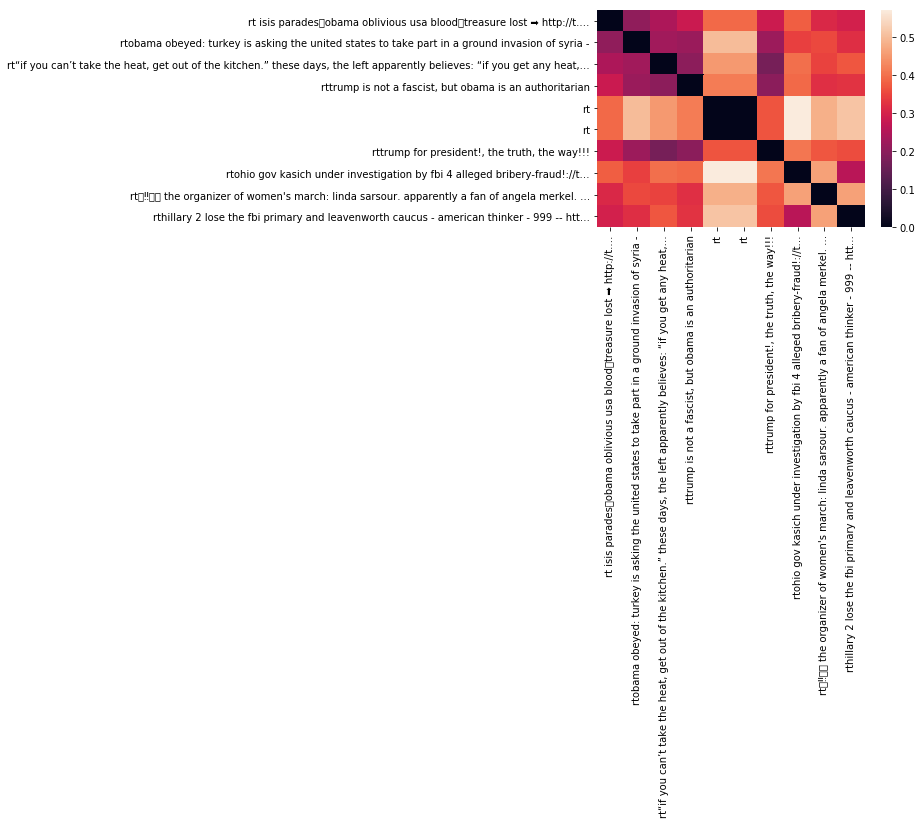

In [15]:
# Word2vec embedding
visualize_dist(w2v_embed_tweets,cleaned_tweets,cleaned_tweets.sample(n=10,random_state=2).index)

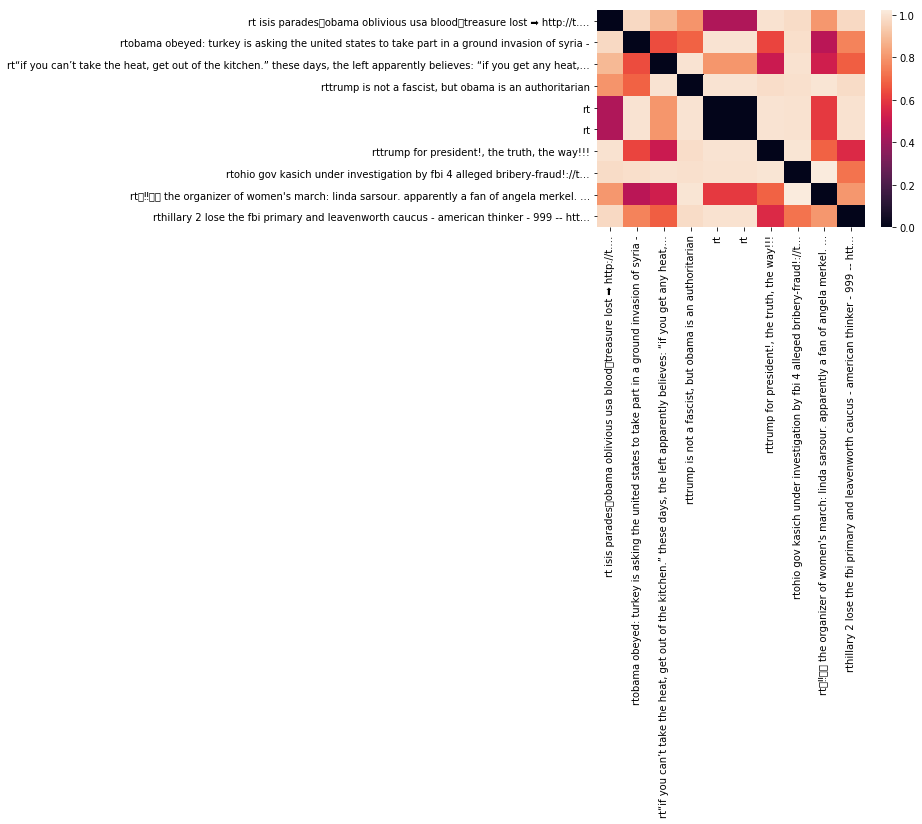

In [16]:
# PCA embedding
visualize_dist(svd_embed,cleaned_tweets,cleaned_tweets.sample(n=10,random_state=2).index)

#### Remarks

Both embeddings work similarly on finding twitter similarities and distance scores are really close.

Also, both detect when two tweets support same political party. For example, tweet number 4 and tweet number 7, which both seem to be written by Trump supporters and have a small distance score between them.